In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

from quilt.data.haradai1262 import YouTuber
%config InlineBackend.figure_format = 'retina'

In [5]:
# thumb_path = './tuber-150/hika_sei/'
thumb_path = './saved/hika_sei/'
dirs = os.listdir( thumb_path ); dirs

['train', 'valid']

In [6]:
data_dir = os.path.join('saved', 'hika_sei')
image_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'))
image, label = image_dataset[0]

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        # transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((256, 256)),
        # transforms.Scale((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

torch.Size([4, 3, 224, 224]) torch.Size([4])


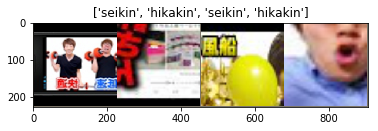

In [11]:


images, classes = next(iter(dataloaders['train']))
print(images.size(), classes.size())  # torch.Size([4, 3, 224, 224]) torch.Size([4])
images = torchvision.utils.make_grid(images)
imshow(images, title=[class_names[x] for x in classes])

In [12]:
use_gpu = torch.cuda.is_available()

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # 各エポックで訓練+バリデーションを実行
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)   # training mode
            else:
                model.train(False)  # evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            for data in dataloaders[phase]:
                inputs, labels = data
                
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # サンプル数で割って平均を求める
            epoch_loss = running_loss / float( dataset_sizes[phase] )
            epoch_acc = running_corrects.double() / float( dataset_sizes[phase] )
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            # 精度が改善したらモデルを保存する
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:.4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
model_ft = models.resnet18(pretrained=True)
num_features = model_ft.fc.in_features; print(num_features);
model_ft.fc = nn.Linear(num_features, 2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\myaun/.torch\models\resnet18-5c106cde.pth
100%|█████████████████████████████████████████████████████████████████| 46827520/46827520 [00:35<00:00, 1312231.75it/s]


512


In [14]:
if use_gpu: model_ft = model_ft.cuda()
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) # 7エポックごとに学習率を0.1倍する
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
torch.save(model_ft.state_dict(), 'model_ft.pkl')

Epoch 0/24
----------


C:\Users\myaun\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


train Loss: 0.7782 Acc: 0.6130
valid Loss: 0.5999 Acc: 0.7700

Epoch 1/24
----------
train Loss: 0.7234 Acc: 0.6801
valid Loss: 0.5211 Acc: 0.8000

Epoch 2/24
----------
train Loss: 0.5944 Acc: 0.7371
valid Loss: 0.7800 Acc: 0.6900

Epoch 3/24
----------
train Loss: 0.6710 Acc: 0.7170
valid Loss: 0.3437 Acc: 0.8800

Epoch 4/24
----------
train Loss: 0.6674 Acc: 0.7181
valid Loss: 0.3815 Acc: 0.9000

Epoch 5/24
----------
train Loss: 0.6123 Acc: 0.7506
valid Loss: 0.5014 Acc: 0.8400

Epoch 6/24
----------
train Loss: 0.5482 Acc: 0.7573
valid Loss: 0.3742 Acc: 0.8800

Epoch 7/24
----------
train Loss: 0.4447 Acc: 0.8020
valid Loss: 0.3170 Acc: 0.8800

Epoch 8/24
----------
train Loss: 0.4002 Acc: 0.8020
valid Loss: 0.3139 Acc: 0.8700

Epoch 9/24
----------
train Loss: 0.3860 Acc: 0.8311
valid Loss: 0.3225 Acc: 0.9000

Epoch 10/24
----------
train Loss: 0.4070 Acc: 0.8110
valid Loss: 0.2986 Acc: 0.9100

Epoch 11/24
----------
train Loss: 0.3614 Acc: 0.8177
valid Loss: 0.2932 Acc: 0.9100



In [15]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters(): param.requires_grad = False # すべてのパラメータを固定
num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, 2)

In [16]:
if use_gpu: model_conv = model_conv.cuda()
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9) # Optimizerの第1引数には更新対象のfc層のパラメータのみ指定
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)
torch.save(model_conv.state_dict(), 'model_conv.pkl')

Epoch 0/24
----------


C:\Users\myaun\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


train Loss: 0.7433 Acc: 0.6085
valid Loss: 0.5631 Acc: 0.7000

Epoch 1/24
----------
train Loss: 0.7610 Acc: 0.6454
valid Loss: 0.4778 Acc: 0.8000

Epoch 2/24
----------
train Loss: 0.6279 Acc: 0.6779
valid Loss: 0.4712 Acc: 0.7500

Epoch 3/24
----------
train Loss: 0.7589 Acc: 0.6577
valid Loss: 0.5708 Acc: 0.7200

Epoch 4/24
----------
train Loss: 0.7379 Acc: 0.6454
valid Loss: 0.5050 Acc: 0.7700

Epoch 5/24
----------
train Loss: 0.7371 Acc: 0.6790
valid Loss: 0.6281 Acc: 0.7200

Epoch 6/24
----------
train Loss: 0.7475 Acc: 0.6488
valid Loss: 0.5227 Acc: 0.7900

Epoch 7/24
----------
train Loss: 0.5775 Acc: 0.7069
valid Loss: 0.3870 Acc: 0.8200

Epoch 8/24
----------
train Loss: 0.5271 Acc: 0.7181
valid Loss: 0.3678 Acc: 0.8300

Epoch 9/24
----------
train Loss: 0.5099 Acc: 0.7595
valid Loss: 0.4104 Acc: 0.8300

Epoch 10/24
----------
train Loss: 0.5339 Acc: 0.7483
valid Loss: 0.4429 Acc: 0.7600

Epoch 11/24
----------
train Loss: 0.5877 Acc: 0.6890
valid Loss: 0.3914 Acc: 0.8500



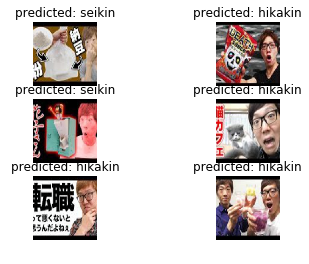

In [32]:
# GPUで学習したモデルのロード
model_ft.load_state_dict(torch.load('model_ft.pkl', map_location=lambda storage, loc: storage))

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for i, data in enumerate(dataloaders['valid']):
        inputs, labels = data
        
        if use_gpu: inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else: inputs, labels = Variable(inputs), Variable(labels)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_images:
                return

visualize_model(model_ft)

In [68]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=10)
        images = ims[i].numpy().transpose((1, 2, 0))  # (h, w, c)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        images = std * images + mean
        images = np.clip(images, 0, 1)       
        plt.imshow(images)

def plot_with_title(imgs, titles, title):
    print(title)
    return plots(imgs, rows=1, titles=titles, figsize=(16,8))

In [69]:
preds_all = []
trues_all = []
sm = torch.nn.Softmax()
imgs = []
titles = []
for i, data in enumerate( dataloaders['valid'] ):
    inputs, labels = data
    if use_gpu: inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs.data, 1)
    preds_list, trues_list = preds.cpu().numpy().tolist(), labels.cpu().numpy().tolist()
    preds_all.extend( preds_list )
    trues_all.extend( trues_list )
    for j, p in enumerate( preds_list ):
        if not p == trues_list[j]:
            # imshow( inputs.cpu().data[j], 'predict: %s' % class_names[p] )
            imgs.append( inputs.cpu().data[j] )
            titles.append( 'predict: %s' % class_names[p] )
            # plt.show()

incorrectly classified


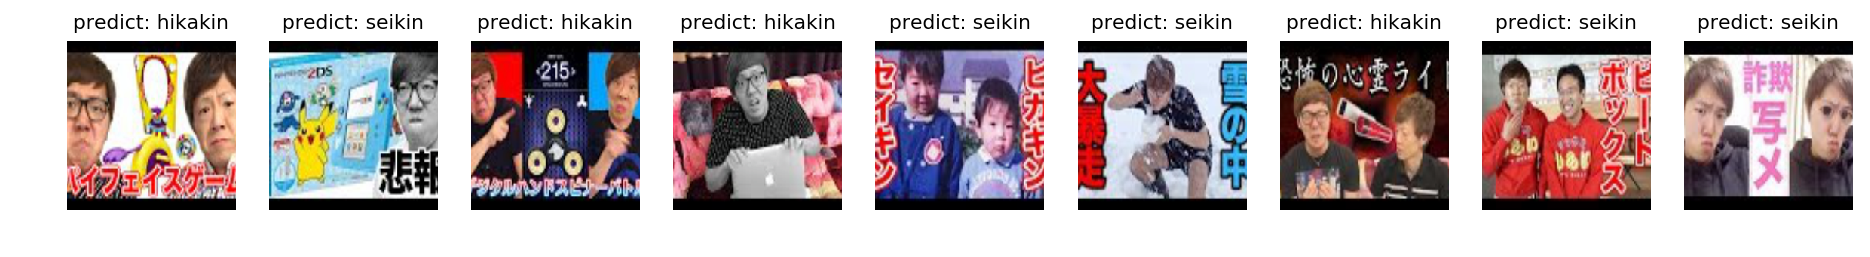

In [70]:
plot_with_title( imgs, titles, "incorrectly classified")

In [34]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
cmx = confusion_matrix(trues_all, preds_all)
cmx_df = pd.DataFrame( cmx, index=class_names, columns=class_names )

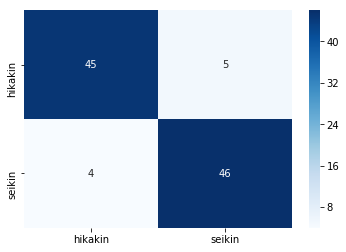

In [35]:
sn.heatmap( cmx_df, cmap='Blues', annot=True)

In [25]:
from sklearn.metrics import classification_report
cls_repo = classification_report(trues_all, preds_all, target_names=class_names)

In [26]:
print( cls_repo )

             precision    recall  f1-score   support

    hikakin       0.92      0.90      0.91        50
     seikin       0.90      0.92      0.91        50

avg / total       0.91      0.91      0.91       100

